# Hybrid attack

### Load results 

In [15]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from IPython.display import display
from itertools import product
from Graph import Graph

# parameters 

sns.set(font_scale=1.2)
sns.set_theme(style="whitegrid")

log_columns = ["expe","attack_type","optim","alpha","beta","gamma","graph1_prop","common_prop",
        "iter_number","impossible_edges","reconstructed_edges","unknown_edges",
        "TP","FP","TN","FN","G2_distance","time"]

graph_stats = {
    "netscience": (379, 914, 14662),
    "bio-diseasome": (516, 1188, 21332),
    "cora": (2485, 5069, 113964),
    "polblogs": (1490, 16715, 2716480),
    "cora_logs": (2485, 5069)
}



# Deterministic attacks

       attack  prop  run  value
100    degree   1.0    0      0
101    degree   1.0    1      0
102    degree   1.0    2      0
103    degree   1.0    3      0
104    degree   1.0    4      0
..        ...   ...  ...    ...
765  triangle   1.0    5      0
766  triangle   1.0    6      0
767  triangle   1.0    7      0
768  triangle   1.0    8      0
769  triangle   1.0    9      0

[70 rows x 4 columns]
       attack  prop  run  value
100    degree   1.0    0      0
101    degree   1.0    1      0
102    degree   1.0    2      0
103    degree   1.0    3      0
104    degree   1.0    4      0
..        ...   ...  ...    ...
765  triangle   1.0    5      0
766  triangle   1.0    6      0
767  triangle   1.0    7      0
768  triangle   1.0    8      0
769  triangle   1.0    9      0

[70 rows x 4 columns]
       attack  prop  run  value
100    degree   1.0    0      0
101    degree   1.0    1      0
102    degree   1.0    2      0
103    degree   1.0    3      0
104    degree   1.0    4  

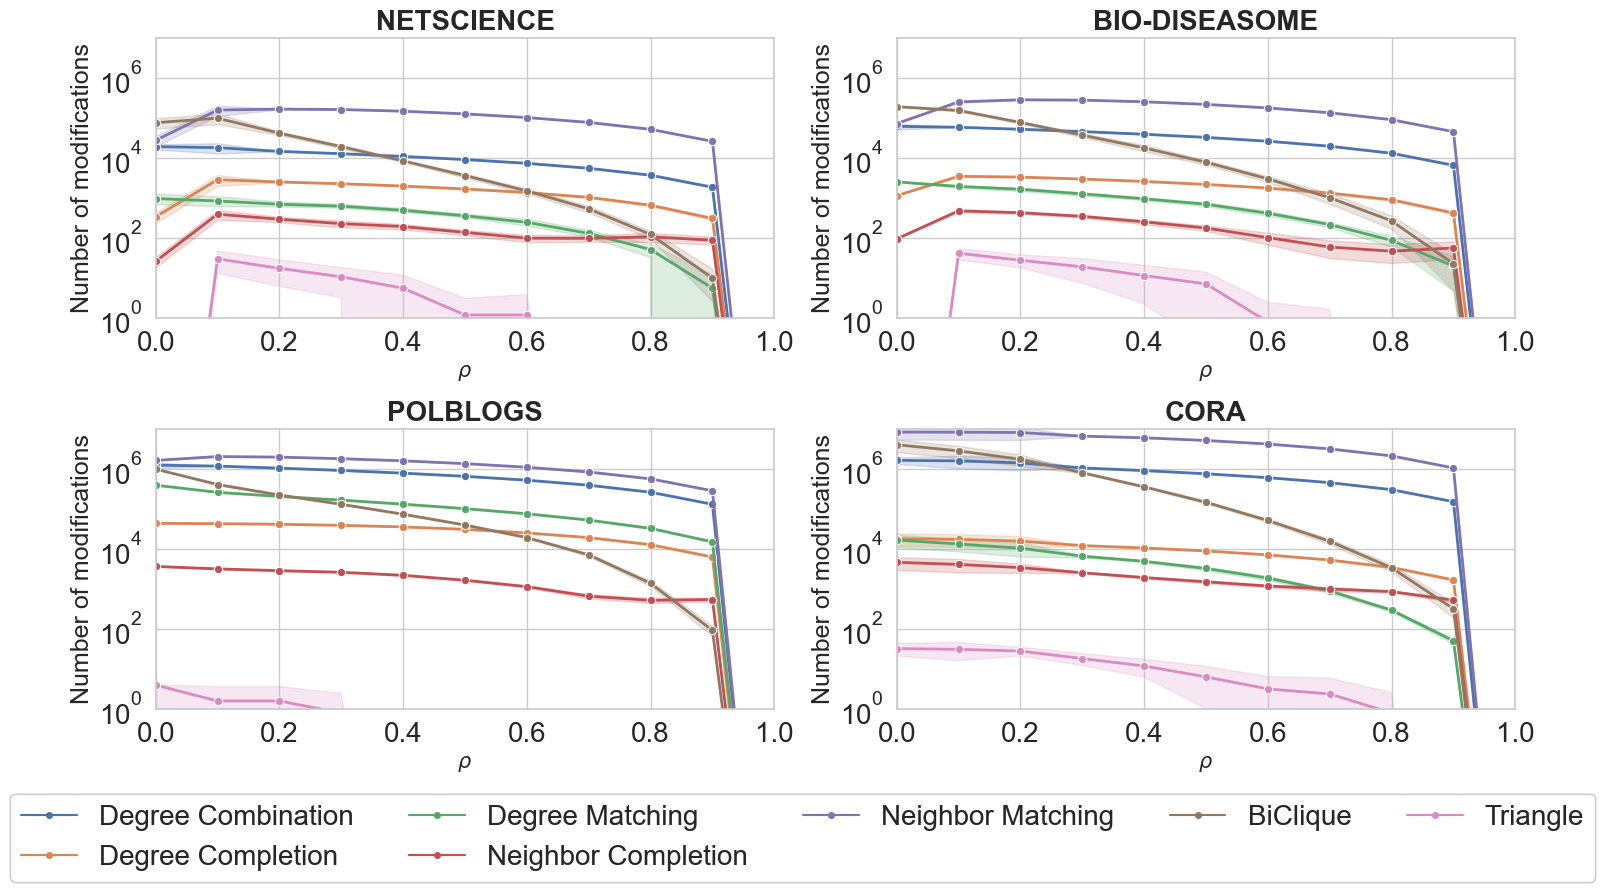

In [16]:
from matplotlib.lines import Line2D

datasets = ["netscience", "bio-diseasome", "polblogs", "cora"]

fig = plt.figure(figsize=(15, 8))
for i, result in enumerate(datasets):
    data = pd.read_csv(f'logs/deterministics/backup/{result}.csv')
    data.columns = ['attack', 'run', 'prop', 'value']
    values = data.groupby(['attack', 'prop', 'run']).sum("value").reset_index()


    print(values[values["prop"] == 1.0])

    values['attack'] = values['attack'].map({
        "degree_completion": "Degree Completion",
        "degree_matching": "Degree Matching",
        "neighbor_matching": "Neighbor Matching",
        "neighbor_completion": "Neighbor Completion",
        "triangle": "Triangle",
        "degree": "Degree Combination",
        "rectangle": "BiClique",
    })

    values['value'] = values['value'].replace(0, 1e-10)
    ax = fig.add_subplot(2, 2, i+1)   
    sns.lineplot(data=values, x="prop", y="value", hue='attack', marker="o", dashes=False, ax=ax, errorbar='sd', linewidth=2)
    ax.set_yscale('log')
    ax.set_title(result.upper(), fontdict={'fontsize': 20, 'fontweight': 'bold'})
    ax.set_xlabel(r"$\rho$", fontdict={'fontsize': 15})
    ax.set_ylabel("Number of modifications", fontdict={'fontsize': 18})
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 1e7)
    # disable the legend in the subplots
    ax.get_legend().remove()
    ax.tick_params(axis='both', which='major', labelsize=20)


    custom_lines = [
    Line2D([0], [0], color=sns.color_palette()[i], marker='o', markersize=4, label=attack) 
    for i, attack in enumerate(["Degree Combination", "Degree Completion", "Degree Matching", "Neighbor Completion", "Neighbor Matching", "BiClique", "Triangle"])
    ]
    fig.legend(
        handles=custom_lines,
        loc='lower center',
        fontsize=20,
        ncol=5,
        bbox_to_anchor=(0.5, -0.13)
    )


plt.tight_layout()
plt.show()

# RAE-Uninformed attacker

/var/folders/zf/mm8hyjbs5kdg2gxhblkfwn0c0000gn/T/ipykernel_41819/2153137779.py:41: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 5e-1)
/var/folders/zf/mm8hyjbs5kdg2gxhblkfwn0c0000gn/T/ipykernel_41819/2153137779.py:41: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 5e-1)
/var/folders/zf/mm8hyjbs5kdg2gxhblkfwn0c0000gn/T/ipykernel_41819/2153137779.py:41: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 5e-1)
/var/folders/zf/mm8hyjbs5kdg2gxhblkfwn0c0000gn/T/ipykernel_41819/2153137779.py:41: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 5e-1)


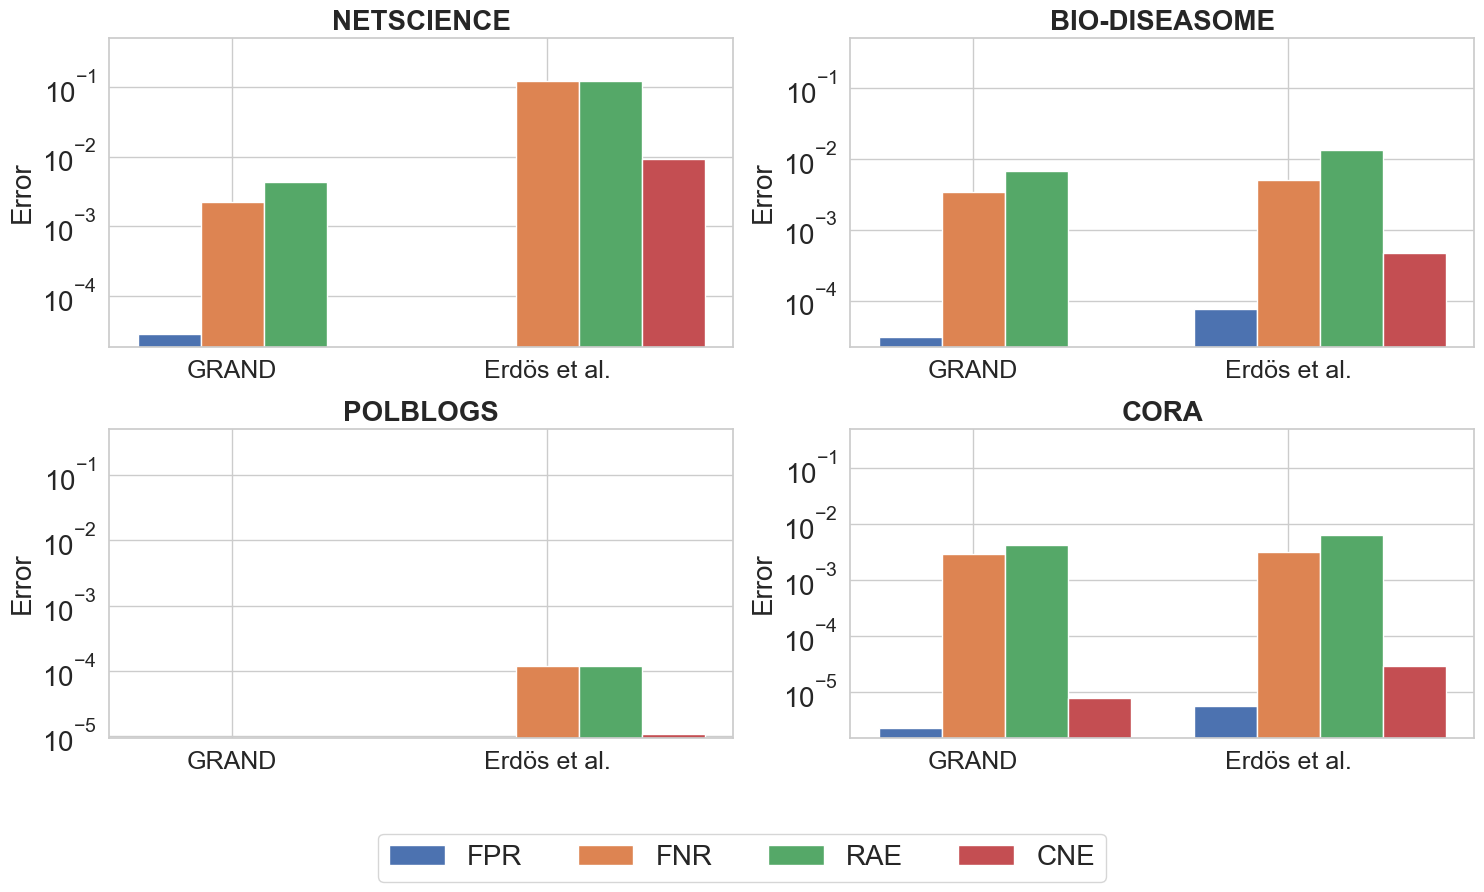

In [17]:

datasets = ["netscience", "bio-diseasome", "polblogs", "cora"]


fig = plt.figure(figsize=(15, 8))
colors = color=sns.color_palette()
for i, result in enumerate(datasets):
    data = pd.read_csv(f"logs/benchmark/backup/{result}.csv")
    data.columns = log_columns

    data = data[(data["graph1_prop"] == 0) & ((data["attack_type"] == "H") | ( ( data["attack_type"].str.startswith("DDH")) & (data["optim"] == 1) & (data["alpha"] == 0.0) & (data["beta"] == 0.0) & (data["gamma"] == 0)))]
    data = data.groupby(["attack_type"]).mean(["FP", "TP", "FN", "TN"]).reset_index()

    data.loc[:, "RAE"] = (data["FP"] + data["FN"]) / (data["TP"] + data["FN"])
    data["beta"] = data["beta"].replace(0, "|E*|/n^2")
    data["alpha"] = data["alpha"].replace(0, "1-beta")
    data["attack_type"] = data["attack_type"].replace("H", "Erdös et al.")
    data["attack_type"] = data["attack_type"].replace("DDH.*", "GRAND", regex=True)
    
    # compute false positive rate and false negative rate
    data["FP"] = data["FP"] / (data["FP"] + data["TN"])
    data["FN"] = data["FN"] / (data["FN"] + data["TP"])
    

    ax = fig.add_subplot(2, 2, i+1)   
    # data["G2_distance"] = data["G2_distance"] * (graph_stats[result][0] ** 2) / graph_stats[result][2]
    
    x = np.arange(len(data))
    width = 0.2

    ax.bar(x - width, data["FP"], width, label="FPR", color=colors[0])
    ax.bar(x, data["FN"], width, label="FNR", color=colors[1])
    ax.bar(x + width, data["RAE"], width, label="RAE", color=colors[2])
    ax.bar(x + 2*width, data["G2_distance"], width, label="CNE", color=colors[3])

    ax.set_xticks(range(len(data)))
    ax.set_xticklabels(data["attack_type"], rotation=0, fontsize=18)
    ax.set_title(result.upper(), fontdict={'fontsize': 20, 'fontweight': 'bold'})
    # ax2.set_ylabel("RAE", fontsize=18)
    ax.set_ylabel("Error", fontsize=20)
    ax.set_yscale("log")
    ax.set_ylim(0, 5e-1)
    ax.tick_params(axis='y', which='major', labelsize=20)


plt.tight_layout()
fig.legend(["FPR", "FNR", "RAE", "CNE"], loc='lower center', fontsize=20, ncol=4, bbox_to_anchor=(0.5, -0.13))
plt.show()

    

------ Dataset is netscience
------ Dataset is bio-diseasome
------ Dataset is polblogs
------ Dataset is cora


/var/folders/zf/mm8hyjbs5kdg2gxhblkfwn0c0000gn/T/ipykernel_41819/1154069901.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ours_normal.loc[:, "missing_edges"] = number_total_edges - ours_normal["reconstructed_edges"]
/var/folders/zf/mm8hyjbs5kdg2gxhblkfwn0c0000gn/T/ipykernel_41819/1154069901.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ours_normal.loc[:, "RAE_max"] = (ours_normal["FP"] + ours_normal["FN"] + 2 * ours_normal["missing_edges"]) / (ours_normal["TP"] + ours_normal["FN"])
/var/folder

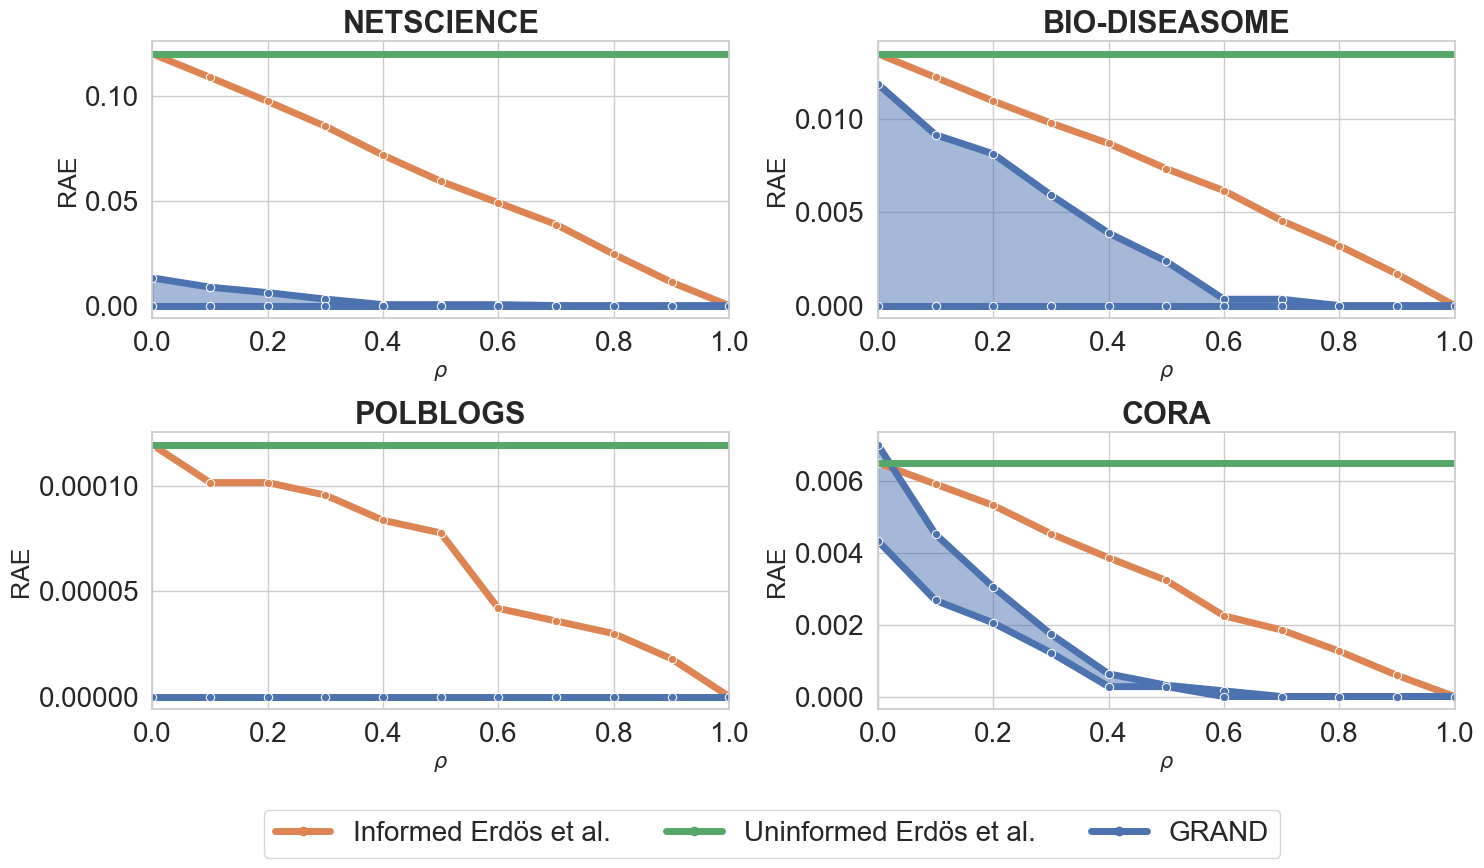

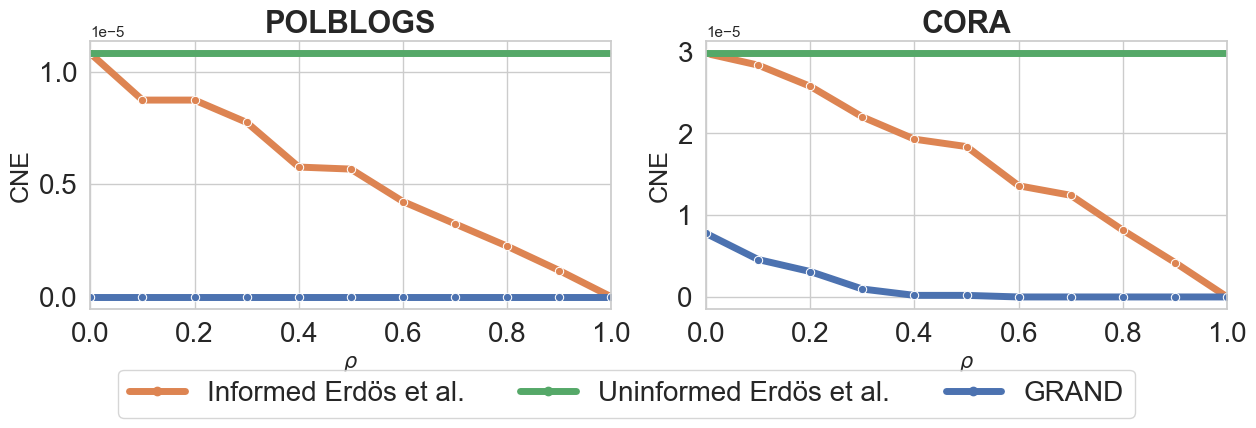

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D



def plot_rae(datasets):
    colors = color=sns.color_palette()
    sns.set_theme(style="whitegrid")

    fig = plt.figure(figsize=(15, 8))
    # 
    for i, result in enumerate(datasets):
        print("------ Dataset is", result)
        data = pd.read_csv(f"logs/benchmark/backup/{result}.csv")

        data.columns = ["expe","attack_type","optim","alpha","beta","gamma","graph1_prop","common_prop",
        "iter_number","impossible_edges","reconstructed_edges","unknown_edges",
        "TP","FP","TN","FN","G2_distance","time"]

        data = data[((data["attack_type"] == "H") | 
        ( ( data["attack_type"].str.startswith("DDH")) & 
        (data["alpha"] == 0) & 
        (data["beta"] == 0) & 
        (data["gamma"] == 0)))]
        
        data["attack_type"] = data["attack_type"].replace("H", "Erdos et al.")
        data["attack_type"] = data["attack_type"].replace("DDH.*", "GRAND", regex=True)
        # data["G2_distance"] = data["G2_distance"] * (graph_stats[result][0] ** 2) / graph_stats[result][2]

        ours_normal = data[(data["attack_type"] == "GRAND") & (data["optim"] == False)]
        ours_opti = data[(data["attack_type"] == "GRAND") & (data["optim"] == True)]

        number_total_edges = data.iloc[2]["TP"] + data.iloc[2]["FN"]

        ours_normal.loc[:, "missing_edges"] = number_total_edges - ours_normal["reconstructed_edges"]

        ours_normal.loc[:, "RAE_max"] = (ours_normal["FP"] + ours_normal["FN"] + 2 * ours_normal["missing_edges"]) / (ours_normal["TP"] + ours_normal["FN"])
        ours_normal = ours_normal.groupby("graph1_prop").mean(["RAE_max"]).reset_index()

        ours_opti.loc[:, "RAE_min"] = np.where(ours_opti["G2_distance"] == 0, 0, (ours_opti["FP"] + ours_opti["FN"]) / (ours_opti["TP"] + ours_opti["FN"]))
        ours_opti = ours_opti.groupby("graph1_prop").mean(["RAE_min"]).reset_index()

        erdos_et_al = data[data["attack_type"] == "Erdos et al."]

        erdos_et_al.loc[:, "RAE"] = (erdos_et_al["FP"] + erdos_et_al["FN"]) / (erdos_et_al["TP"] + erdos_et_al["FN"])
        basic_erdos = erdos_et_al[erdos_et_al["graph1_prop"] == 0.0]

        ax = fig.add_subplot(2, 2, i+1)  

        line1 = sns.lineplot(data=erdos_et_al, x="graph1_prop", y="RAE", ax=ax, color=colors[1], marker='o', errorbar=None, linewidth=5)
        line2 = sns.lineplot(data=ours_normal, x='graph1_prop', y='RAE_max', ax=ax, color=colors[0], marker='o', errorbar=None, linewidth=5)
        line3 = sns.lineplot(data=ours_opti, x='graph1_prop', y='RAE_min', ax=ax, color=colors[0], marker='o' , errorbar=None, linewidth=5)
        sns.lineplot(x=erdos_et_al["graph1_prop"], y=basic_erdos["RAE"][0], ax=ax, color=colors[2],errorbar=None, linewidth=5)

        ax.fill_between(ours_normal['graph1_prop'], ours_normal['RAE_max'], ours_opti['RAE_min'], color=colors[0], alpha=0.5)
        
        ax.set_title(result.upper(), fontdict={'fontsize': 22, 'fontweight': 'bold'})
        ax.set_xlabel(r"$\rho$", fontsize=15)
        ax.set_ylabel("RAE", fontsize=18)
        ax.set_xlim(0, 1)
        # ax.set_ylim(0, 0.13)
        ax.tick_params(axis='both', which='major', labelsize=20)

    custom_legend = [
        Line2D([0], [0], color=colors[1], marker='o', linestyle='-', label="Informed Erdös et al.", linewidth=5),
        Line2D([0], [0], color=colors[2], marker='o', linestyle='-', label="Uninformed Erdös et al.", linewidth=5),
        Line2D([0], [0], color=colors[0], marker='o', linestyle='-', label="GRAND", linewidth=5),
    ]

    fig.legend(handles=custom_legend, loc='lower center', fontsize=20, ncol=3, bbox_to_anchor=(0.52, -0.1))

    plt.tight_layout() 
    plt.show()



def plot_g2_distance(datasers):
    colors = color=sns.color_palette()

    fig = plt.figure(figsize=(25, 4))
    # 
    for i, result in enumerate(datasets):
        data = pd.read_csv(f"logs/benchmark/backup/{result}.csv")

        data.columns = ["expe","attack_type","optim","alpha","beta","gamma","graph1_prop","common_prop",
        "iter_number","impossible_edges","reconstructed_edges","unknown_edges",
        "TP","FP","TN","FN","G2_distance","time"]

        data = data[((data["attack_type"] == "H") | 
        ( ( data["attack_type"].str.startswith("DDH")) & 
        (data["alpha"] == 0) & 
        (data["beta"] == 0) & 
        (data["gamma"] == 0)))]
        
        data["attack_type"] = data["attack_type"].replace("H", "Erdos et al.")
        data["attack_type"] = data["attack_type"].replace("DDH.*", "GRAND", regex=True)
        
        # data["G2_distance"] = data["G2_distance"] * (graph_stats[result][0] ** 2) / graph_stats[result][2]

        ours_opti = data[(data["attack_type"] == "GRAND") & (data["optim"] == True)]
        erdos_et_al = data[data["attack_type"] == "Erdos et al."]
        basic_erdos = erdos_et_al[erdos_et_al["graph1_prop"] == 0.0]

        ax = fig.add_subplot(1, 4, i+1)  

        line1 = sns.lineplot(data=erdos_et_al, x="graph1_prop", y="G2_distance", ax=ax, color=colors[1], marker='o', errorbar=None, linewidth=5)
        line2 = sns.lineplot(data=ours_opti, x='graph1_prop', y='G2_distance', ax=ax, color=colors[0], marker='o', errorbar=None, linewidth=5)
        sns.lineplot(x=erdos_et_al["graph1_prop"], y=basic_erdos["G2_distance"][0], ax=ax, color=colors[2], linewidth=5)

        ax.set_title(result.upper(), fontdict={'fontsize': 22, 'fontweight': 'bold'})
        ax.set_xlabel(r"$\rho$", fontsize=15)
        ax.set_ylabel("CNE", fontsize=18)
        ax.set_xlim(0, 1)
        # ax.set_ylim(0, 0.008)
        ax.tick_params(axis='both', which='major', labelsize=20)

    custom_legend = [
        Line2D([0], [0], color=colors[1], marker='o', linestyle='-', label="Informed Erdös et al.", linewidth=5),
        Line2D([0], [0], color=colors[2], marker='o', linestyle='-', label="Uninformed Erdös et al.", linewidth=5),
        Line2D([0], [0], color=colors[0], marker='o', linestyle='-', label="GRAND", linewidth=5),
    ]

    fig.legend(handles=custom_legend, loc='lower center', fontsize=20, ncol=3, bbox_to_anchor=(0.26, -0.1))

    plt.tight_layout()
    plt.show()
        


# datasets = ['barabasi_100_1', 'barabasi_100_2','barabasi_100_3','barabasi_100_4']
# datasets = ["random_100_0.25", "random_100_0.5", "random_100_0.75", "random_100_1"]
datasets = ["netscience", "bio-diseasome", "polblogs", "cora"]

plot_rae(datasets)

datasets = ["polblogs", "cora"]
plot_g2_distance(datasets)